<a href="https://colab.research.google.com/github/vinay-pv/DA203o_Genre_Classification/blob/main/genre_classification_using_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from keras.utils.vis_utils import plot_model
from sklearn.metrics import hamming_loss, f1_score, average_precision_score, roc_auc_score, coverage_error, recall_score

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AIML Project/features_augmented.csv')
print(df.shape)

(104343, 521)


In [ ]:
#df_cleaned = df.drop(columns=list(drop_col.keys()))
df_cleaned = df.drop(columns='Unnamed: 0')
df_cleaned.dropna(subset=['genre_list'], inplace=True)
print(df_cleaned.shape)

(104343, 520)


In [ ]:
#df_cleaned.to_csv("/content/sample_data/features_cleaned.csv")

In [ ]:
N = 50000

df_clean_25k = df_cleaned.sample(n=N, random_state=42)
print(df_clean_25k.shape)

X = df_clean_25k.drop(['track_id', 'genre_list'], axis=1)
y = df_clean_25k['genre_list']
print(y.shape)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(50000, 520)
(50000,)
(50000, 61)
(40000, 518)
(10000, 518)


In [ ]:
#PCA with all modes 
pca100pc = PCA(n_components=X_train.shape[1])
pca100pc.fit(X_train)

PCA(n_components=518)

Text(0, 0.5, 'Explained variance')

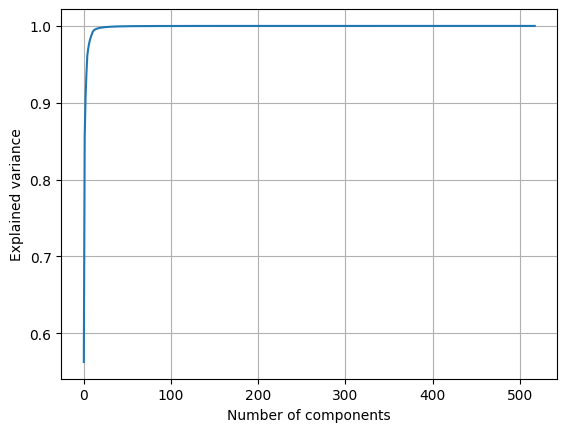

In [ ]:
#Plot variance v/s number of modes
plt.grid()
plt.plot(np.cumsum(pca100pc.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

In [ ]:
cumulative_variance = np.cumsum(pca100pc.explained_variance_ratio_)
feature_percent = 0.999
num_pca_modes_999 = np.searchsorted(cumulative_variance, feature_percent) + 1
print("Minimum number of modes:", num_pca_modes_999)

Minimum number of modes: 33


In [ ]:
pca999pc = PCA(n_components=num_pca_modes_999)
pca999pc.fit(X_train)
X_train_pca999pc = pca999pc.transform(X_train)
print("Train shape:", X_train_pca999pc.shape)

Train shape: (40000, 33)


In [ ]:
input_dim = X_train_pca999pc.shape[1]
output_dim = y_train.shape[1]

model = keras.Sequential([
    Dense(256, activation='relu', input_dim=input_dim),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(output_dim, activation='sigmoid')
])

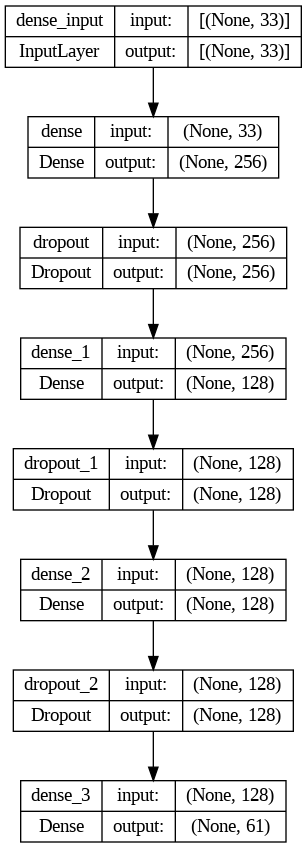

In [ ]:
# plot the model architecture
plot_model(model, to_file='genre_classification_dnn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
history = model.fit(X_train_pca999pc, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
1000/1000 [==============================] - 5s 4ms/step - loss: 1.7384 - val_loss: 0.3728
Epoch 2/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3692 - val_loss: 0.3543
Epoch 3/20
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3595 - val_loss: 0.3527
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3572 - val_loss: 0.3523
Epoch 5/20
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3554 - val_loss: 0.3522
Epoch 6/20
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3546 - val_loss: 0.3522
Epoch 7/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.3540 - val_loss: 0.3521
Epoch 8/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3537 - val_loss: 0.3521
Epoch 9/20
1000/1000 [==============================] - 5s 5ms/step - loss: 0.3536 - val_loss: 0.3521
Epoch 10/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.353

In [ ]:
# Make predictions on test data
X_test_pca999pc = pca999pc.transform(X_test)
y_pred = model.predict(X_test_pca999pc)

# Threshold predictions to obtain binary labels
Y_pred_binary = (y_pred > 0.5).astype(int)

# Compute metrics
hl = hamming_loss(y_test, Y_pred_binary)
f1 = f1_score(y_test, Y_pred_binary, average='micro')
ap = average_precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, Y_pred_binary, average='micro')
auroc = roc_auc_score(y_test, y_pred, average='micro')
ce = coverage_error(y_test, y_pred)

print('Hamming loss:', hl)
print('F1 score:', f1)
print('Average precision score:', ap)
print('Recall:', recall)
print('Coverage error:', ce)


313/313 [==============================] - 1s 3ms/step
Hamming loss: 0.15795409836065574
F1 score: 0.717391431873244
Average precision score: 0.8034260014684291
Recall: 0.675883451790116
Coverage error: 36.7534
